In [2]:
import os
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

from matplotlib import dates
import datetime

from heapq import nsmallest

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import seaborn as sns
from neuralprophet import NeuralProphet, set_log_level

import warnings

In [3]:
holidays=['2020-01-01','2020-01-06','2020-04-12','2020-04-13','2020-05-01','2020-05-03',
          '2020-05-31', '2020-06-11','2020-08-15','2020-11-01','2020-11-11','2020-12-25',
          '2020-12-26','2021-01-01','2021-01-06','2021-04-04','2021-04-05','2021-05-01',
          '2021-05-03','2021-05-23','2021-06-03','2021-08-15','2021-11-01','2021-11-11',
          '2021-12-25','2021-12-26', '2022-01-01','2022-01-06', '2022-04-01','2022-04-02','2022-04-03','2022-04-04','2022-04-05',
          '2022-04-27','2022-04-28','2022-04-29','2022-04-30',
          '2022-05-01', '2022-05-02','2022-05-03','2022-05-04',
          '2022-05-23','2022-06-03','2022-08-15','2022-11-01','2022-11-11',
          '2022-12-25','2022-12-26'
         ]

state = pd.DataFrame({'ds': pd.to_datetime(holidays),
                      'holiday': 'state_holiday'
                      })
holidays = state

In [4]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[:6] == 'zakupy']

In [5]:
df = pd.DataFrame()
for f in files_csv:
    data = pd.read_excel(f)
    df = df.append(data)

df.head(3)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)



,NumerZlecenia,LokalizacjaAkcji,LokalizacjaPoczatkowa,LokalizacjaKoncowa,CzasPrzejazdu,PrzebytyDystans,SredniaPredkosc,OcenaJazdyExpress,OcenaPredkosciExpress,OcenaOgolnaExpress,...,SamochodId,NumerRejestracyjny,Subsystem,Stan,DataDodania,Uwagi,SklepTrafiszopId,NazwaSklepu,AdresSklepu,MiastoSklepu
0,ZT/2021/2248344,Kraków,"Kraków, Tyniecka 188","Kraków, Tyniecka 188",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,brak,Zamkniete,2021-01-01 12:05:50.7683578,Osoba kontaktowa: 508905857 | Godzina dostar...,4,SPOŁEM Kraków,Daszyńskiego 3 31-537 Kraków,Kraków
1,ZT/2021/2248353,Łódź,"Łódź, ul. Żeligowskiego 8/10 - 24h","Łódź, ul. Żeligowskiego 8/10 - 24h",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,brak,Zamkniete,2021-01-01 12:34:11.5504132,Osoba kontaktowa: 608824286 | Godzina dostar...,28,Carrefour Bandurskiego,Bandurskiego 49 94-020 Łódź,Łódź
2,ZT/2021/2248355,Katowice,"Katowice, Siemianowicka 52C - 24h","Katowice, Siemianowicka 52C - 24h",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,brak,Zamkniete,2021-01-01 13:02:39.4225176,Osoba kontaktowa: 511461537 Notatka klienta: ...,3,SPOŁEM Katowice,Mickiewicza 4 40-954 Katowice,Katowice


In [6]:
df=df.reset_index()
del df['index']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155773 entries, 0 to 155772
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NumerZlecenia                 155773 non-null  object 
 1   LokalizacjaAkcji              154854 non-null  object 
 2   LokalizacjaPoczatkowa         155773 non-null  object 
 3   LokalizacjaKoncowa            155773 non-null  object 
 4   CzasPrzejazdu                 872 non-null     float64
 5   PrzebytyDystans               872 non-null     float64
 6   SredniaPredkosc               872 non-null     float64
 7   OcenaJazdyExpress             872 non-null     float64
 8   OcenaPredkosciExpress         872 non-null     float64
 9   OcenaOgolnaExpress            872 non-null     float64
 10  NajwyzszaPredkosc             872 non-null     float64
 11  OcenaRezerwacjiCms            0 non-null       float64
 12  IdWsparciaCms                 0 non-null    

In [7]:
#Lokalizacje akcji zapełnic miastem sklepu
df.LokalizacjaAkcji.fillna(df.MiastoSklepu, inplace=True)
#Wyrzucenie kolumn z brakiem DatyRozpoczęcia / data rozpoczęcia może wystąpić w następnych dniach od planowanej
df = df.dropna(subset=['DataRozpoczecia'])
df=df.reset_index()
del df['index']

In [8]:
# zmiana formatu daty na datetime
df['PlanowanaDataRozpoczecia']= pd.to_datetime(df['PlanowanaDataRozpoczecia'])
df['PlanowanaDataZakonczenia']= pd.to_datetime(df['PlanowanaDataZakonczenia'])
df['DataZakonczenia']= pd.to_datetime(df['DataZakonczenia'])
df['ZadeklarowanaData']= pd.to_datetime(df['ZadeklarowanaData'])
df['DataRozpoczecia']= pd.to_datetime(df['DataRozpoczecia'])
df['DataDodania']= pd.to_datetime(df['DataDodania'])

In [9]:
#Wyrzucenie kolumn gdzie data zakonczenia jest przed data rozpoczecia
df = df[df['DataZakonczenia']>df['DataRozpoczecia']]
print(len(df))

152371


In [10]:
#Dodanie kolumny z numeryczna wartością dla dnia tygodnia(0-poniedziałek itd.)
#df['day_of_week'] = df['PlanowanaDataRozpoczecia'].dt.day_name() #wartość string
df['day_of_week'] = df['PlanowanaDataRozpoczecia'].dt.dayofweek #wartosć numeryczna
df['Lp'] = 1 

In [11]:
# usunięcie niedziel
df_weekdays = df[df['DataRozpoczecia'].dt.dayofweek < 6]
# df_weekdays = df
df_weekdays = df_weekdays.reset_index()
df_weekdays = df_weekdays.drop(columns=['index'])


In [12]:
# Lista miast
city_list = ['Kraków' 'Łódź' 'Katowice' 'Warszawa' 'Wrocław' 'Poznań' 'Gdańsk'
 'Chorzów' 'Białystok' 'Lublin' 'Gliwice' 'Szczecin' 'Sosnowiec'
 'Bielsko-Biała' 'Piotrków Trybunalski' 'Bytom' 'Jaworzno' 'Rybnik'
 'Wołomin' 'Radom' 'Mińsk Mazowiecki']

big_city_list = ['Warszawa', 'Kraków', 'Wrocław']

In [13]:
#Sprzedaż danego dnia tygodnia
data_sales_weekday = df.groupby(df['day_of_week']).agg({"Lp":"sum"})
#Sprzedaż w danych godzinach
data_sales_hour = df.groupby(df['DataRozpoczecia'].dt.hour).agg({"Lp":"sum"})
#Sprzedaż danego dnia miesiąca
data_sales_day = df.groupby(df['DataRozpoczecia'].dt.day).agg({"Lp":"sum"})
#Sprzedaż danego miesiąca
data_sales_month = df.groupby(df['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
#Sprzedaż danego roku
data_sales_year = df.groupby(df['DataRozpoczecia'].dt.year).agg({"Lp":"sum"})
#Sprzedaż w danych godzinach - Data zakończenia
data_sales_hour_z = df.groupby(df['DataZakonczenia'].dt.hour).agg({"Lp":"sum"})
#Sprzedaż danego tygodnia w roku
data_sales_week = df.groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1539491939.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_sales_week = df.groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})



In [14]:
# podzial na miasta
df_warszawa = df.loc[df['MiastoSklepu'] == 'Warszawa']
df_krakow = df.loc[df['MiastoSklepu'] == 'Kraków']
df_wroclaw = df.loc[df['MiastoSklepu'] == 'Wrocław']


In [15]:
#podział na dni

date_sales = df.groupby(pd.to_datetime(df['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
warsaw_date_sales = df_warszawa.groupby(pd.to_datetime(df_warszawa['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
krakow_date_sales = df_krakow.groupby(pd.to_datetime(df_krakow['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
wroclaw_date_sales = df_wroclaw.groupby(pd.to_datetime(df_wroclaw['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})

In [16]:
# odszumianie danych - uzupelnianie dat pustych, lub o wartosci mniejszej niz
# 10% sredniej ilosci z danego miesiaca poprzez interpolacje "niemalymi"
# wartosciami z okolicznych dat

years = [2020, 2021, 2022]
idx = pd.date_range('2020-10-30', '2022-08-25')
wwa_idx = pd.date_range('2020-10-30', '2022-08-25')
krk_idx = pd.date_range('2020-10-30', '2022-08-25')
wr_idx = pd.date_range('2020-10-30', '2022-08-25')


year_sales_dict = {}
year_sales_dict_week = {}

year_sales_dict_wwa = {}
year_sales_dict_week_wwa = {}

year_sales_dict_wr = {}
year_sales_dict_week_wr = {}

year_sales_dict_krk = {}
year_sales_dict_week_krk = {}

date_sales_un = date_sales.reindex(idx, fill_value=0)
date_sales_un = date_sales_un.reset_index()

date_sales_wwa_un = warsaw_date_sales.reindex(idx, fill_value=0)
date_sales_wwa_un = date_sales_wwa_un.reset_index()

date_sales_krk_un = krakow_date_sales.reindex(idx, fill_value=0)
date_sales_krk_un = date_sales_krk_un.reset_index()

date_sales_wr_un = wroclaw_date_sales.reindex(idx, fill_value=0)
date_sales_wr_un = date_sales_wr_un.reset_index()

date_sales_un = date_sales_wwa_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_wwa_un = date_sales_wwa_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_krk_un = date_sales_krk_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_wr_un = date_sales_wr_un.rename(columns={'index': 'ds', 'Lp': 'y'})

if 'DataRozpoczecia' in date_sales_un.columns.values.tolist():
    date_sales_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_wwa_un.columns.values.tolist():
    date_sales_wwa_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_krk_un.columns.values.tolist():
    date_sales_krk_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_wr_un.columns.values.tolist():
    date_sales_wr_un.drop(['DataRozpoczecia'], axis=1)

for year in years:
    year_sales_dict[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})
    
    year_sales_dict_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    year_sales_dict_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_krakow['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_krakow['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    year_sales_dict_wr[year]=df_wroclaw[df_wroclaw['DataRozpoczecia'].dt.year == year].groupby(df_wroclaw['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_wr[year]=df_wroclaw[df_wroclaw['DataRozpoczecia'].dt.year == year].groupby(df_wroclaw['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    
for key, value in year_sales_dict.items():
    value = value.to_dict()['Lp']
    year_sales_dict[key] = value
    
for key, value in year_sales_dict_week.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week[key] = value
    
for key, value in year_sales_dict_wwa.items():
    value = value.to_dict()['Lp']
    year_sales_dict_wwa[key] = value
    
for key, value in year_sales_dict_week_wwa.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_wwa[key] = value
    
for key, value in year_sales_dict_krk.items():
    value = value.to_dict()['Lp']
    year_sales_dict_krk[key] = value
    
for key, value in year_sales_dict_week_krk.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_krk[key] = value
    
for key, value in year_sales_dict_wr.items():
    value = value.to_dict()['Lp']
    year_sales_dict_wr[key] = value
    
for key, value in year_sales_dict_week_wr.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_wr[key] = value
    
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict[year][month]/30
    
    if week in year_sales_dict_week[year].keys():
        avg_week_sales = year_sales_dict_week[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_un.at[index, 'y'] = int(avg_week_sales)
        
#     odszumienie zbioru danych dla warszawy
            
for index, row in date_sales_wwa_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_wwa[year][month]/30
    
    if week in year_sales_dict_week_wwa[year].keys():
        avg_week_sales = year_sales_dict_week_wwa[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_wwa_un.at[index, 'y'] = int(avg_week_sales)

        
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_krk_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_krk[year][month]/30
    
    if week in year_sales_dict_week_krk[year].keys():
        avg_week_sales = year_sales_dict_week_krk[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_krk_un.at[index, 'y'] = int(avg_week_sales)

        
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_wr_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_wr[year][month]/30
    
    if week in year_sales_dict_week_wr[year].keys():
        avg_week_sales = year_sales_dict_week_wr[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_wr_un.at[index, 'y'] = int(avg_week_sales)


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1141912089.py:55: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1141912089.py:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4278/1141912089.py:61: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_kr

In [17]:
# przygotowanie danych dla modelu prophet
prepared_date_sales = date_sales_un
prepared_wroclaw_date_sales = date_sales_wr_un
prepared_krakow_date_sales = date_sales_krk_un
prepared_warszawa_date_sales = date_sales_wwa_un

prepared_date_sales.set_index('ds')
# prepared_date_sales['ds'] = prepared_date_sales.index
# prepared_date_sales = prepared_date_sales.reset_index()
# print(prepared_date_sales.head(1)['ds'].to_numpy()[0].weekday())


# # usuniecie niedziel
# prepared_date_sales = prepared_date_sales[prepared_date_sales['ds'].to_numpy()[0].weekday() < 6]
# prepared_date_sales=prepared_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_date_sales=prepared_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_wroclaw_date_sales['ds'] = prepared_wroclaw_date_sales.index
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.reset_index()
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_krakow_date_sales['ds'] = prepared_krakow_date_sales.index
# prepared_krakow_date_sales = prepared_krakow_date_sales.reset_index()
# prepared_krakow_date_sales = prepared_krakow_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_krakow_date_sales = prepared_krakow_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_warszawa_date_sales['ds'] = prepared_warszawa_date_sales.index
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.reset_index()
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_warszawa_date_sales.head(20)

,ds,y
0,2020-10-30,4
1,2020-10-31,36
2,2020-11-01,7
3,2020-11-02,54
4,2020-11-03,35
5,2020-11-04,37
6,2020-11-05,69
7,2020-11-06,86
8,2020-11-07,87
9,2020-11-08,62


In [18]:
# train datasets for cities
train_3, train_7, train_30, train_120 = [], [], [], []

# Poland
train_3 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])
train_7 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-7:])
train_30 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-30:])
train_120 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-120:])


# Warszawa
wwa_train_3 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])
wwa_train_7 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-7:])
wwa_train_30 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-30:])
wwa_train_120 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-120:])

wwa_train_last_10 = prepared_warszawa_date_sales.tail(10)
wwa_train_last_30 = prepared_warszawa_date_sales.tail(30)
wwa_train_last_60 = prepared_warszawa_date_sales.tail(60)
wwa_train_last_100 = prepared_warszawa_date_sales.tail(100)

# Krakow
krk_train_3 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-3:])
krk_train_7 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-7:])
krk_train_30 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-30:])
krk_train_120 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-120:])

krk_train_last_10 = prepared_krakow_date_sales.tail(10)
krk_train_last_30 = prepared_krakow_date_sales.tail(30)
krk_train_last_50 = prepared_krakow_date_sales.tail(50)
krk_train_last_100 = prepared_krakow_date_sales.tail(100)

# Wroclaw
wr_train_3 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-3:])
wr_train_7 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-7:])
wr_train_30 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-30:])
wr_train_120 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-120:])

wr_train_last_10 = prepared_wroclaw_date_sales.tail(10)
wr_train_last_30 = prepared_wroclaw_date_sales.tail(30)
wr_train_last_50 = prepared_wroclaw_date_sales.tail(50)
wr_train_last_100 = prepared_wroclaw_date_sales.tail(100)


prepared_warszawa_date_sales.head(20)

,ds,y
0,2020-10-30,4
1,2020-10-31,36
2,2020-11-01,7
3,2020-11-02,54
4,2020-11-03,35
5,2020-11-04,37
6,2020-11-05,69
7,2020-11-06,86
8,2020-11-07,87
9,2020-11-08,62


In [19]:
def quality_metrics(y, y_hat):
    print('MAE:', np.mean(np.abs(y - y_hat)))
    print('RMSE:', np.sqrt(np.mean(np.square(y - y_hat))))
    print('MAPE:', np.mean(np.abs((y - y_hat)/y)*100))
    print('MAX:', np.max(np.abs(y - y_hat)))
    mae = np.mean(np.abs(y - y_hat))
    rmse = np.sqrt(np.mean(np.square(y - y_hat)))
    mape = np.mean(np.abs((y - y_hat)/y)*100)
    maxi = np.max(np.abs(y - y_hat))
    return ([mae, rmse, mape, maxi])

In [20]:
model_1 = prophet.Prophet(
#                           interval_width = 0.95,
                          changepoint_prior_scale = 0.05,
                          seasonality_prior_scale = 10,
#                           holidays_prior_scale = 0.1,
                          changepoint_range=0.8,
                          yearly_seasonality=True,
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          seasonality_mode = 'multiplicative',
                          holidays = holidays
                           )
model_1.add_seasonality(name='monthly', period=30, fourier_order=5)

In [21]:
# trenowanie modelu
prepared_warszawa_date_sales['ds']
model_1.fit(wwa_train_120)

forecast = model_1.predict(pd.DataFrame(prepared_warszawa_date_sales['ds']))

# model_1.make_all_seasonality_features(pd.DataFrame(prepared_warszawa_date_sales['ds']))

# y_true = wwa_train_120['y'][-120:].values 
# y_pred = forecast['yhat'][-120:].values

15:29:26 - cmdstanpy - INFO - Chain [1] start processing
15:29:26 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# analiza danych zwracanych przez prophet

# df z wartosciami wspolczynnikow trendu i sezonowosci razem z numerami dni tygodnia
forecast_weekday = pd.DataFrame(forecast[['yhat', 'trend', 'monthly', 'daily', 'weekly', 'yearly']])
forecast_weekday['ds'] = date_sales_un['ds']
forecast_weekday['weekday'] = unweighted_values['ds'].dt.dayofweek #wartosć numeryczna
forecast_weekday.head()

# unweighted_values = pd.DataFrame(forecast['yhat']/(forecast['multiplicative_terms']*forecast['trend']), columns=['avg'])

# # dodanie kolumny z data aby umozliwic wyznaczenie sredniej sprzedazy dla poszczegolnych dni
# unweighted_values['ds'] = date_sales_un['ds']
# unweighted_values['weekday'] = unweighted_values['ds'].dt.dayofweek #wartosć numeryczna

# avg_unweighted_values_by_weekday = unweighted_values.groupby(unweighted_values['weekday']).agg({"avg":"mean"})

# print(avg_unweighted_values_by_weekday.head(20))
# unweighted_values.tail(120)

# # unweighted_values_avg = unweighted_values['avg'].mean()
# # print(unweighted_values_avg)
# # print(unweighted_values.tail(30))

# # print(forecast[['weekly', 'yearly', 'monthly', 'daily', 'multiplicative_terms', 'trend']].tail(300))
# # forecast.info()

NameError: name 'unweighted_values' is not defined

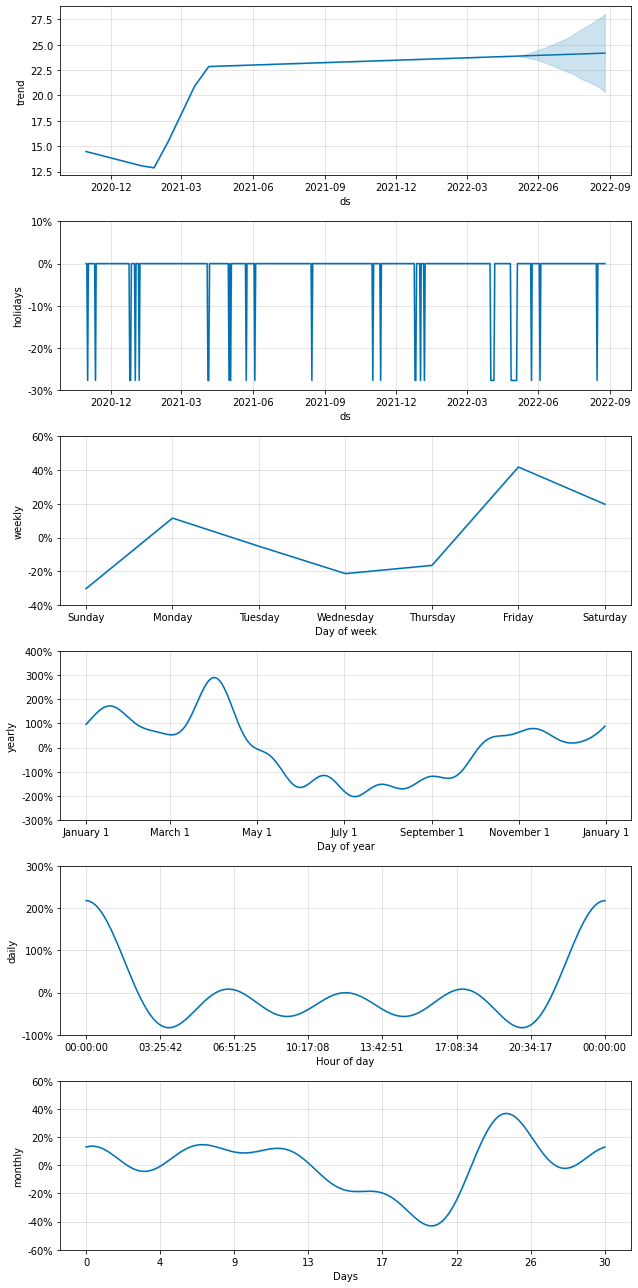

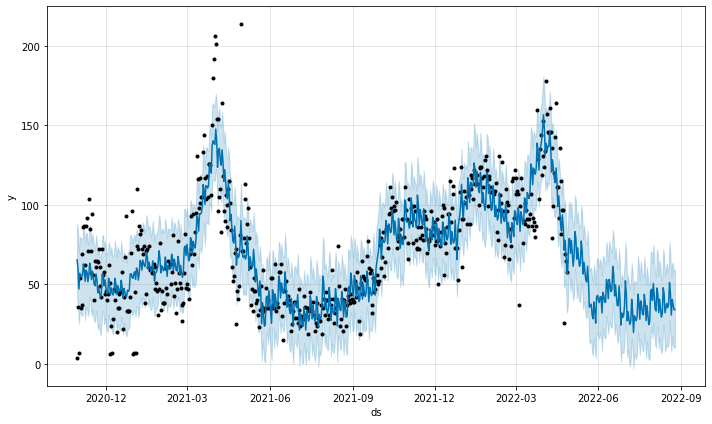

In [39]:
# wykresy sezonowosci
model_1.plot_components(forecast, uncertainty=True)
model_1.plot(forecast);

In [25]:
# komponenty sezonowosci
# w efekcie uzyskane wspolczynniki sezonowosci dla kazdego z dni
seasonal_components = model_1.predict_seasonal_components(forecast).iloc[150+365]
# print(seasonal_components)

In [26]:
# wspolczynniki trendu
trend_component = model_1.predict_seasonal_components(forecast)
# prediction = model_1.predict()
# print(trend_component.info())
print(trend_component.multiplicative_terms)


0      3.518646
1      3.152922
2      2.260094
3      2.955768
4      2.885503
         ...   
660    0.270732
661    0.678374
662    0.548560
663    0.408016
664    0.413149
Name: multiplicative_terms, Length: 665, dtype: float64


In [29]:
# komponenty sezonowosci
seasonality_features = model_1.make_all_seasonality_features(forecast)[0]
print(seasonality_features)
# print(seasonality_features['multiplicative']['multiplicative_terms'])

     monthly_delim_1  monthly_delim_2  monthly_delim_3  monthly_delim_4  \
0          -0.926324        -0.376728         0.697944        -0.716152   
1          -0.983798        -0.179281         0.352752        -0.935717   
2          -0.999668         0.025748        -0.051479        -0.998674   
3          -0.973264         0.229688        -0.447094        -0.894487   
4          -0.905702         0.423914        -0.767880        -0.640593   
..               ...              ...              ...              ...   
660         0.882679        -0.469977        -0.829677        -0.558244   
661         0.767880        -0.640593        -0.983798        -0.179281   
662         0.620609        -0.784120        -0.973264         0.229688   
663         0.447094        -0.894487        -0.799839         0.600214   
664         0.254671        -0.967028        -0.492548         0.870285   

     monthly_delim_5  monthly_delim_6  monthly_delim_7  monthly_delim_8  \
0           0.400454    

In [28]:
weekdays_data=df.groupby(df['day_of_week']).agg({"Lp":"sum"})
weekdays_data_avg=df.groupby(df['day_of_week']).agg({"Lp":"sum"})
weekday_occ_dict = {}
first_date = df.head(1)['DataRozpoczecia'].dt.date.values[0]
last_date = df.tail(1)['DataRozpoczecia'].dt.date.values[0]
dates = df['DataRozpoczecia'].dt.date.unique()
for date in dates:
    if date.weekday()+1 not in weekday_occ_dict.keys():
        weekday_occ_dict[date.weekday()+1] = 1
    else:
        weekday_occ_dict[date.weekday()+1] += 1

print(weekday_occ_dict)

for index, row in weekdays_data.iterrows():
    weekdays_data_avg.at[index, 'Lp'] = row['Lp']/weekday_occ_dict[index+1]

{4: 90, 6: 90, 2: 94, 1: 90, 5: 91, 3: 93, 7: 21}
